Utilisation de l'appareil : cpu
Classes : ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Images d'entraînement : 60000
Images de test : 10000


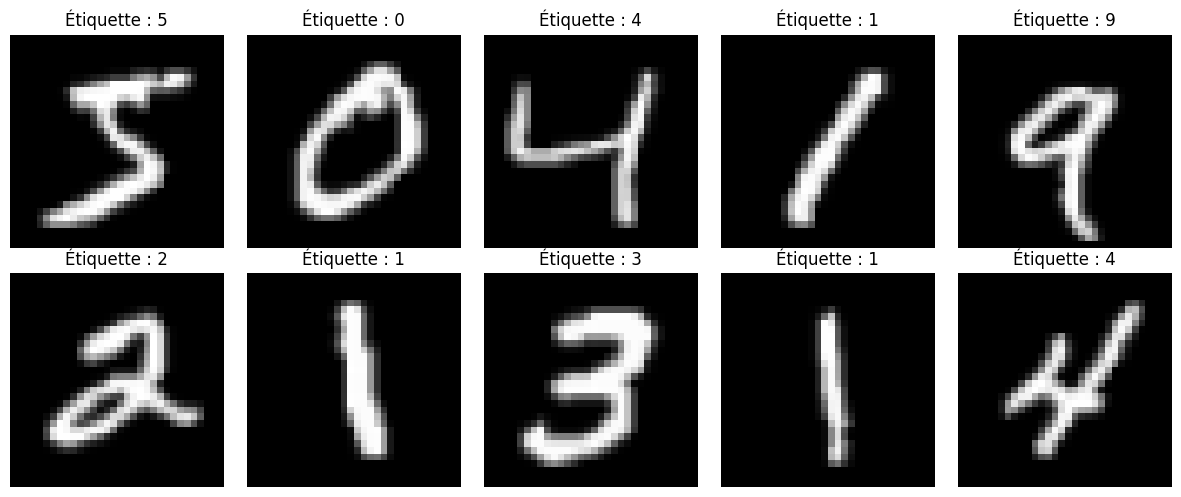

ModeleClassificationImage(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Forme de sortie : torch.Size([1, 10])
Époque 1/15
---------------------------------------
perte : 2.335208 [   64/60000]
perte : 2.303025 [ 6464/60000]
perte : 2.285895 [12864/60000]
perte : 2.307040 [19264/60000]
perte : 2.306341 [25664/60000]
perte : 2.280669 [32064/60000]
perte : 2.292272 [38464/60000]
perte : 2.238143 [44864/60000]
perte : 2.198491 [51264/60000]
perte : 1.978065 [57664/60000]
Erreur de test : 
 Précision : 57.4%, Perte moyenne : 1.762936 

✓ Nouveau meilleur modèle sauvegardé ! Précision : 57.4%
Époque 2/15
---------------------------------------
perte : 1.770484 [   64/60000]
perte : 0.841437 [ 6464/60000]
perte : 0.548861 [12864/60000]
pe

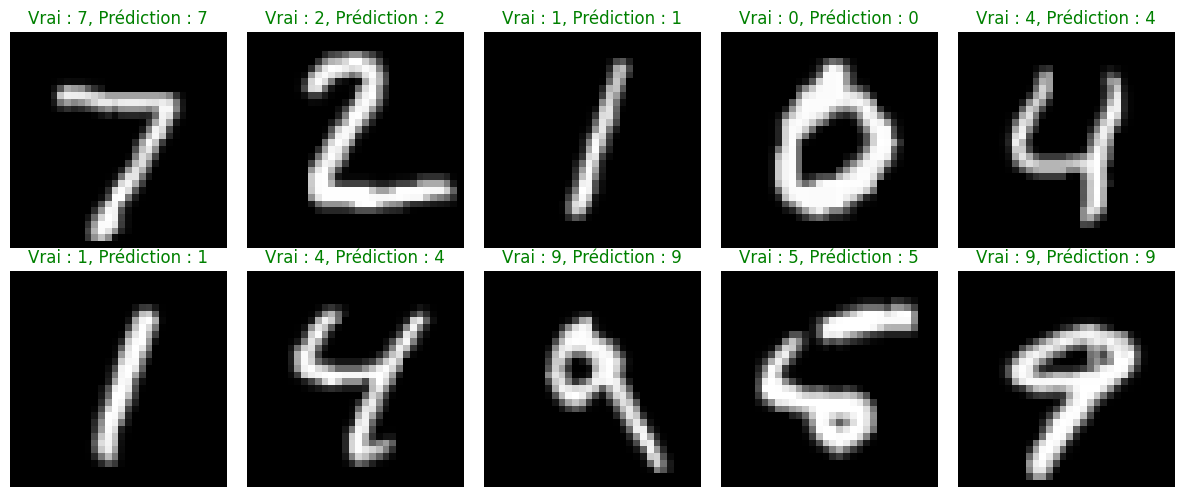

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Resize
import matplotlib.pyplot as plt

# ============================================
# 1. CONFIGURATION
# ============================================
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Utilisation de l'appareil : {device}")

# ============================================
# 2. CHARGEMENT DES DONNÉES
# ============================================
# Utiliser 32x32 pour correspondre au modèle CNN
donnees_entrainement = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([
        Resize((32, 32)),
        ToTensor()
    ])
)

donnees_test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=Compose([
        Resize((32, 32)),
        ToTensor()
    ])
)

dataloader_entrainement = DataLoader(donnees_entrainement, batch_size=64, shuffle=True, pin_memory=True, num_workers=4)
dataloader_test = DataLoader(donnees_test, batch_size=64, shuffle=False, pin_memory=True, num_workers=4)

print(f"Classes : {donnees_entrainement.classes}")
print(f"Images d'entraînement : {len(donnees_entrainement)}")
print(f"Images de test : {len(donnees_test)}")

# ============================================
# 3. VISUALISATION DES DONNÉES
# ============================================
# Afficher quelques exemples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = donnees_entrainement[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"Étiquette : {label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# ============================================
# 4. DÉFINITION DU MODÈLE CNN
# ============================================
class ModeleClassificationImage(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Créer le modèle
modele = ModeleClassificationImage().to(device)
print(modele)

# Tester la forme de sortie
X_test = torch.rand(1, 1, 32, 32, device=device)
logits = modele(X_test)
print(f"Forme de sortie : {logits.shape}")

# ============================================
# 5. LOSS ET OPTIMISEUR
# ============================================
fonction_perte = nn.CrossEntropyLoss()
optimiseur = torch.optim.SGD(modele.parameters(), lr=1e-3, momentum=0.9)

# ============================================
# 6. FONCTIONS D'ENTRAÎNEMENT ET TEST
# ============================================
def entrainer(dataloader, modele, fonction_perte, optimiseur):
    taille = len(dataloader.dataset)
    modele.train()
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Passe avant
        pred = modele(X)
        perte = fonction_perte(pred, y)

        # Passe arrière
        perte.backward()
        optimiseur.step()
        optimiseur.zero_grad()

        if batch_idx % 100 == 0:
            valeur_perte, actuel = perte.item(), (batch_idx + 1) * len(X)
            print(f"perte : {valeur_perte:>7f} [{actuel:>5}/{taille:>5}]")

def tester(dataloader, modele, fonction_perte):
    taille = len(dataloader.dataset)
    num_batches = len(dataloader)
    modele.eval()
    perte_test, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = modele(X)
            perte_test += fonction_perte(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    perte_test /= num_batches
    precision = correct / taille
    print(f"Erreur de test : \n Précision : {(100*precision):>0.1f}%, Perte moyenne : {perte_test:>8f} \n")
    return precision

# ============================================
# 7. ENTRAÎNEMENT
# ============================================
epochs = 15
meilleure_precision = 0.0

for t in range(epochs):
    print(f"Époque {t+1}/{epochs}\n---------------------------------------")
    entrainer(dataloader_entrainement, modele, fonction_perte, optimiseur)
    precision = tester(dataloader_test, modele, fonction_perte)
    
    # Sauvegarder le meilleur modèle
    if precision > meilleure_precision:
        meilleure_precision = precision
        torch.save(modele.state_dict(), "meilleur_modele.pth")
        print(f"✓ Nouveau meilleur modèle sauvegardé ! Précision : {100*precision:.1f}%")

print("Terminé ! Entraînement complété.")
print(f"Meilleure précision : {100*meilleure_precision:.1f}%")

# ============================================
# 8. TESTER LE MODÈLE SUR QUELQUES EXEMPLES
# ============================================
modele.eval()
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

with torch.no_grad():
    for i, ax in enumerate(axes.flat):
        img, label = donnees_test[i]
        img_batch = img.unsqueeze(0).to(device)
        
        pred = modele(img_batch)
        pred_label = pred.argmax(1).item()
        
        ax.imshow(img.squeeze(), cmap='gray')
        couleur = 'green' if pred_label == label else 'red'
        ax.set_title(f"Vrai : {label}, Prédiction : {pred_label}", color=couleur)
        ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# ============================================
# 9. EXPORT VERS ONNX
# ============================================
# Mettre le modèle en mode évaluation
modele.eval()

# Créer un exemple d'entrée
exemple_entree = torch.randn(1, 1, 32, 32).to(device)

# Export ONNX
print("Exportation du modèle vers ONNX...")
torch.onnx.export(
    modele,
    exemple_entree,
    "image_classifier_model.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['x'],
    output_names=['linear_2'],
    dynamic_axes={
        'x': {0: 'batch_size'},
        'linear_2': {0: 'batch_size'}
    }
)

print("✓ Modèle exporté vers image_classifier_model.onnx")

import onnx

# Charger le modèle existant (avec éventuellement fichier .data)
model = onnx.load("image_classifier_model.onnx")

# Sauvegarder en un seul fichier ONNX
onnx.save_model(model, "image_classifier_model_merged.onnx", save_as_external_data=False)


C:\Users\Talyha Moreau\AppData\Local\Temp\ipykernel_6580\979945872.py:12: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W1211 12:16:48.357000 6580 Lib\site-packages\torch\onnx\_internal\exporter\_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


Exportation du modèle vers ONNX...
[torch.onnx] Obtain model graph for `ModeleClassificationImage([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ModeleClassificationImage([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


The model version conversion is not supported by the onnxscript version converter and fallback is enabled. The model will be converted using the onnx C API (target version: 11).
Failed to convert the model to the target version 11 using the ONNX C API. The model was not modified
Traceback (most recent call last):
  File "c:\Users\Talyha Moreau\Documents\IIM\IA\Projet_IA\venv\Lib\site-packages\onnxscript\version_converter\__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Talyha Moreau\Documents\IIM\IA\Projet_IA\venv\Lib\site-packages\onnxscript\version_converter\_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "c:\Users\Talyha Moreau\Documents\IIM\IA\Projet_IA\venv\Lib\site-packages\onnxscript\version_converter\__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 1 of general pattern rewrite rules.
✓ Modèle exporté vers image_classifier_model.onnx
